 # PVRP

従来のVRPでは、通常、計画期間は1日です。 Period Vehicle Routing Problem（PVRP）の場合、従来のVRPは計画期間をM日まで延長することにより一般化されます。

目的：目的は、車両群とすべての顧客に供給するために必要な移動時間の合計を最小限にすることです。

### データの読み方
index =顧客番号

x = x座標

y = y座標

d =サービス期間

q =需要

f =訪問の頻度

a =可能な訪問の組み合わせの数

list =すべての可能な訪問の組み合わせのリスト

 ## 定式化

$$
minimize \sum_{ij}^{}c_{ij}x_{ijt} \quad　(i<j)
$$

$$
s. t \sum_{j}^{}x_{0jt}\quad <= 2m   \quad\forall{t}\in{T})
$$

$$
 \sum_{i}^{}x_{ijt}+\sum_{j}^{}x_{jit} = 2\sum_{p}a_{ipt}y_{ip}(\forall{i,t}\in{N,T})
$$

$$
\sum_{i}^{}y_{ip}\quad = 1 \quad \forall{}
$$

 ### ●目的
 移動時間の合計（コスト）を最小化


 ### ●制約
点０からでる枝の数は２m本

必ず１度は全ての点を通る

必ずパターンのどれか一つを選ぶ

部分閉路禁止

 ### ●変数
**$C_{ij}$:点iから点jに移動するときの費用**

**$x_{ijt}$:運搬車が点iから点jにt日に移動する回数を表す変数**

**$y_{ip}$:どのパターン（p）で点iに訪れるか**

＊mは車両数

## 必要なライブラリのインポート 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx

In [3]:
f = open("c-pvrp/p01").read()
print()
L = [tuple(map(int , i.split())) for i in f.split("\n") if i != ""]
#for i in L:
#    if i in " ":
#        L.remove(i)      
#print(L)
m = int(L[0][1])
#K = [k for k in range(1,int(L[0][1])+1)] #トラックの集合
#N = [i for i in range(int(L[0][2])+1)] #デポと顧客の集合
#T = [t for t in range(1,int(L[0][3])+1)]#days
T = [t for t in range(int(L[0][3]))]

In [4]:
V, x_y , d  , qq, f , al , li = [] , [] , [] , [] , [] , [] , []
day = L[0][3]
Q = L[1][1]
depo = L[day+1][1:3]
pat = [()]
for i in range(day+1,len(L)):
    V.append(int(L[i][0]))#デポと顧客の集合
    x_y.append((int(L[i][1]),int(L[i][2])))
    d.append(int(L[i][3])) #サービス期間
    qq.append(int(L[i][4])) #顧客ごとの需要
    f.append(int(L[i][5])) #訪問頻度
    al.append(int(L[i][6])) #訪問パターンの総数
    li.append(tuple(L[i][7:]))  

In [5]:
#コスト
c = {}
for i in range(len(x_y)):
    n = 1
    while i+n < len(x_y):
        di = np.sqrt((x_y[i][0] - x_y[i+n][0])**2 + (x_y[i][1] - x_y[i+n][1])**2 )
        c[i,i+n] = di
        n += 1

In [6]:
q = {}
for i in V:
    q[i] = qq[i]

liリストは配達パターン。二進数から１０進数へ変換されている

1日目に配達するなら10で2

2日目に配達するなら01で1

In [7]:
pat = []
for i in range(1,len(li)):
    ll = []
    for j in range(len(li[i])):
        ll.append((format(li[i][j],'b').zfill(day)))
    pat.append(ll)

In [8]:
a = [()]
P = [()]
for i1 in pat:
    ml = []
    for i2 in i1[::-1]:
        ll = []
        for i3 in i2:
            ll.append(int(i3))
        ml.append(ll)
    patdata = np.array(ml)
    n_pat = [i for i in range(len(patdata))]
    #print(patdata)
    a.append(patdata)
    P.append(n_pat)

 # デポと顧客位置の可視化

In [9]:
import numpy as np
x_y = np.array(x_y)
x = x_y[:, 0]
y = x_y[:, 1]
distance = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - y[np.newaxis, :]) ** 2)
# distance[i, j]が都市iと都市jの距離。10個だけ
print(np.round(distance[:10, :10]))

[[ 0. 14. 21. 33. 17. 14. 11. 26. 22. 23.]
 [14.  0. 12. 19. 31. 22. 17. 23. 12. 24.]
 [21. 12.  0. 15. 37. 21. 28. 35. 22. 16.]
 [33. 19. 15.  0. 50. 36. 35. 35. 21. 31.]
 [17. 31. 37. 50.  0. 20. 21. 37. 38. 33.]
 [14. 22. 21. 36. 20.  0. 25. 40. 33. 12.]
 [11. 17. 28. 35. 21. 25.  0. 16. 18. 34.]
 [26. 23. 35. 35. 37. 40. 16.  0. 14. 46.]
 [22. 12. 22. 21. 38. 33. 18. 14.  0. 36.]
 [23. 24. 16. 31. 33. 12. 34. 46. 36.  0.]]


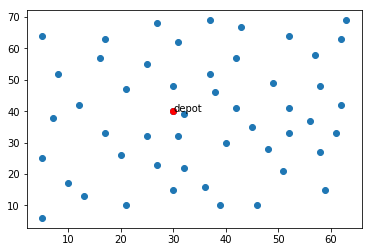

In [10]:
plt.plot(x_y[:, 0], x_y[:, 1], 'o')#"o"は小さい点
plt.plot(x_y[0][0],x_y[0][1],"ro")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")
plt.show()

# gurobiでとく

In [11]:
import math
import random
import networkx
from gurobipy import *

In [12]:
model = Model("vrp")

Academic license - for non-commercial use only


In [13]:
#変数
x = {}
for i in V:
    
    for j in V:
        for t in T:
            if j > i and i == V[0]:       # depot
                x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
            elif j > i:
                x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))


model.update()
#for (i,j,t) in x:
#    print(x[i,j,t])

In [14]:
y = {}
for i in V:
    for p in P[i]:
        y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
model.update()
#for (i,p) in y:
#    print(y[i,p])

In [15]:
#制約
    
#トラックがデポから出発する制約
for t in T:
    model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )

#必ず一台の車両により顧客へのサービスが行われる割り当て制約
for i in V[1:]:
    for t in T:
        model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                        quicksum(x[i,j,t] for j in V if j > i) == 
                        2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))

#必ず全ての顧客を回る制約
for i in V[1:]:
    model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)

model.update()

In [16]:
def vrp_callback(model,where):
    if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
        return
    for t in T:
        edges = []
        for (i,j,t2) in x:
            if model.cbGetSolution(x[i,j,t]) > .5:
                if t == t2 and i != V[0] and j != V[0]:
                    edges.append( (i,j) )
        #print("#############")
        G = networkx.Graph()
        G.add_edges_from(edges)
        Components = networkx.connected_components(G)
        for S in Components:
            S_card = len(S)
            q_sum = sum(q[i] for i in S)
            NS = int(math.ceil(float(q_sum)/Q))
            S_edges = [(i,j) 
                       for i in S 
                       for j in S
                       if i<j and (i,j) in edges]
            if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                model.cbLazy(quicksum(x[i,j,t]
                                      for i in S 
                                      for j in S 
                                      for t in T 
                                      if j > i) <= S_card-NS)
                #print ("adding cut for" , S_edges)
    return

In [17]:
#目的関数
model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                            for i in V
                            for j in V 
                            for t in T
                            if j>i), GRB.MINIMIZE)

model.update()
#model.__data = x

In [18]:
model.params.DualReductions = 0
model.params.LazyConstraints = 1
model.optimize(vrp_callback)
model.Params.Timelimit = 3600
#model.optimize()
#x = model.__data
for t in T:
    edges = []
    for (i,j,t2) in x:
        if x[i,j,t].X > .5:
            if t2 == t and i != V[0] and j != V[0]:
                    edges.append( (i,j) )


print ("Optimal solution:",model.ObjVal)
print ("Edges in the solution:")
print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 155 rows, 2753 columns and 5506 nonzeros
Variable types: 0 continuous, 2753 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 52 rows and 102 columns
Presolve time: 0.02s
Presolved: 103 rows, 2651 columns, 5302 nonzeros
Variable types: 0 continuous, 2651 integer (2550 binary)

Root relaxation: objective 3.793623e+02, 159 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  379.36228    0   38          -  379.36228      -     -    0s
     0     0  443.09979    0   33          -  443.09979      -     -    0s
     0 

In [20]:
opt = model.ObjVal
print(f"最適距離: {opt}")

最適距離: 534.5024977510811


In [21]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(0,1,1) 1.0
x(0,11,1) 1.0
x(0,12,1) 1.0
x(0,14,0) 1.0
x(0,18,0) 1.0
x(0,32,0) 1.0
x(0,38,1) 1.0
x(0,46,1) 1.0
x(0,47,0) 1.0
x(0,48,1) 1.0
x(0,51,0) 2.0
x(1,22,1) 1.0
x(2,11,1) 1.0
x(2,29,1) 1.0
x(3,28,1) 1.0
x(3,36,1) 1.0
x(4,17,0) 1.0
x(4,47,0) 1.0
x(5,46,1) 1.0
x(5,49,1) 1.0
x(6,23,0) 1.0
x(6,27,0) 1.0
x(7,23,0) 1.0
x(7,43,0) 1.0
x(8,26,1) 1.0
x(8,48,1) 1.0
x(9,30,1) 1.0
x(9,38,1) 1.0
x(10,39,1) 1.0
x(10,49,1) 1.0
x(12,37,1) 1.0
x(13,18,0) 1.0
x(13,41,0) 1.0
x(14,25,0) 1.0
x(15,44,1) 1.0
x(15,45,1) 1.0
x(16,21,1) 1.0
x(16,50,1) 1.0
x(17,42,0) 1.0
x(19,40,0) 1.0
x(19,42,0) 1.0
x(20,22,1) 1.0
x(20,35,1) 1.0
x(21,29,1) 1.0
x(24,25,0) 1.0
x(24,43,0) 1.0
x(26,31,1) 1.0
x(27,32,0) 1.0
x(28,31,1) 1.0
x(30,34,1) 1.0
x(33,39,1) 1.0
x(33,45,1) 1.0
x(34,50,1) 1.0
x(35,36,1) 1.0
x(37,44,1) 1.0
x(40,41,0) 1.0
y[1,1] 1.0
y[2,1] 1.0
y[3,1] 1.0
y[4,0] 1.0
y[5,1] 1.0
y[6,0] 1.0
y[7,0] 1.0
y[8,1] 1.0
y[9,1] 1.0
y[10,1] 1.0
y[11,1] 1.0
y[12,1] 1.0
y[13,0] 1.0
y[14,0] 1.0
y[15,1] 1.0
y[16,1] 1.0
y[17,0

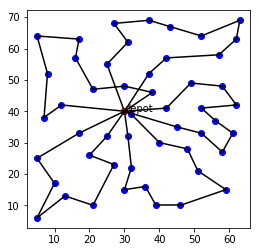

In [22]:
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    for i in V:
        for j in V:
            if i < j and x[i,j,t].x >= 0.9:
                plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

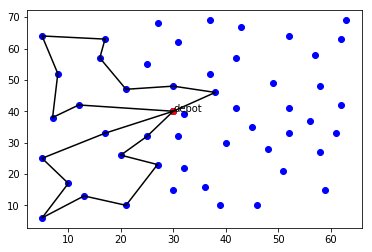

In [23]:
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    if t == 0:
        for i in V:
            for j in V:
                if i < j and x[i,j,t].x >= 0.9:
                    plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

In [24]:
for v in model.getVars():
    if v.X> 0 and v.VarName in y:
        print(v.VarName, v.X)

In [23]:
import math
import random
import networkx
from gurobipy import *

def vrp(V,c,m,q,Q,T,P):
    
    def vrp_callback(model,where):
        if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
            return
        for t in T:
            edges = []
            for (i,j,t2) in x:
                if model.cbGetSolution(x[i,j,t]) > .5:
                    if t == t2 and i != V[0] and j != V[0]:
                        edges.append( (i,j) )
            #print("#############")
            G = networkx.Graph()
            G.add_edges_from(edges)
            Components = networkx.connected_components(G)
            for S in Components:
                S_card = len(S)
                q_sum = sum(q[i] for i in S)
                NS = int(math.ceil(float(q_sum)/Q))
                S_edges = [(i,j) 
                           for i in S 
                           for j in S
                           if i<j and (i,j) in edges]
                if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                    model.cbLazy(quicksum(x[i,j,t]
                                          for i in S 
                                          for j in S 
                                          for t in T 
                                          if j > i) <= S_card-NS)
                    #print ("adding cut for" , S_edges)
        return


    model = Model("vrp")
    
    #変数
    
    x = {}
    for i in V:
        for j in V:
            for t in T:
                if j > i and i == V[0]:
                    x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
                elif j > i:
                    x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))

    #print(x)
    y = {}
    for i in V:
        for p in P[i]:
            y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
    #print(y)
    model.update()
    
    #制約
    
    #トラックがデポから出発する制約
    for t in T:
        model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )
        
    #必ず一台の車両により顧客へのサービスが行われる割り当て制約
    for i in V[1:]:
        for t in T:
            model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                            quicksum(x[i,j,t] for j in V if j > i) == 
                            2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))
            
    #必ず全ての顧客を回る制約
    for i in V[1:]:
        model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)
        
    model.update()
    
    #目的関数
    model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                                for i in V
                                for j in V 
                                for t in T
                                if j>i), GRB.MINIMIZE)

    model.update()
    model.__data = x
    return model,vrp_callback



    
            
if __name__ == "__main__":
    import sys

    model,vrp_callback = vrp(V,c,m,q,Q,T,P)

    model.params.DualReductions = 0
    model.params.LazyConstraints = 1
    model.optimize(vrp_callback)
    x = model.__data
    
    for t in T:
        edges = []
        for (i,j,t2) in x:
            if x[i,j,t2].X > 5:
                if t2 == t and i != V[0] and j != V[0]:
                    edges.append( (i,j) )

    print ("Optimal solution:",model.ObjVal)
    print ("Edges in the solution:")
    print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 155 rows, 2753 columns and 5506 nonzeros
Variable types: 0 continuous, 2753 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+00, 9e+01]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 52 rows and 102 columns
Presolve time: 0.02s
Presolved: 103 rows, 2651 columns, 5302 nonzeros
Variable types: 0 continuous, 2651 integer (2550 binary)

Root relaxation: objective 3.793623e+02, 159 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  379.36228    0   38          -  379.36228      -     -    0s
     0     0  443.09979    0   33          -  443.09979      -     -    0s
     0 

AttributeError: b"Unable to retrieve attribute 'X'"